# Categorical Feature Encoding Challenge Modeling

# 1. Modeling I

이번에는 베이스라인 모델 자체의 성능을 높여보겠습니다.

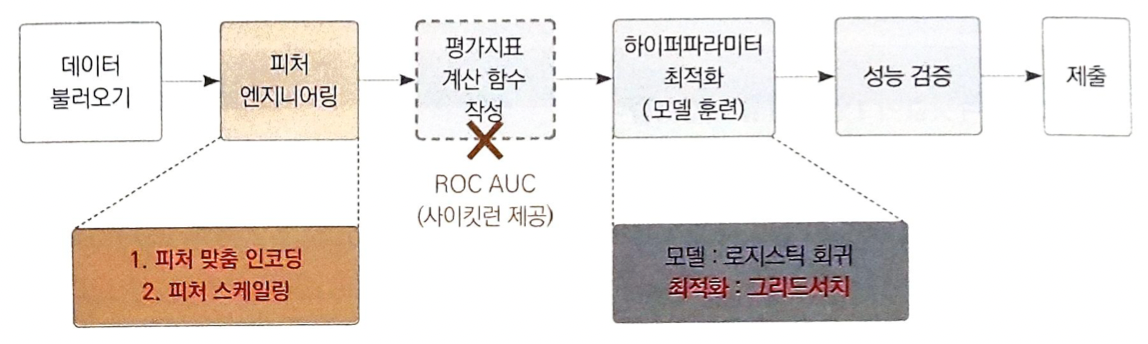

성능 향상을 위해 다음 세 가지에 주안점을 두어 모델링을 진행하겠습니다.
1. 피처 맞춤 인코딩
2. 피처 스케일링
3. 하이퍼파라미터 최적화

첫 번째, 인코딩을 피처 특성에 맞게 적용합니다. 이진 피처와 순서형 피처 ord_1, ord_2는 수작업으로 인코딩을 해줄 겁니다. 그리고 순서형 피처 ord_3, ord_4, ord_5는 ordinal 인코딩을, 명목형 피처와 날짜 피처에는 원-핫 인코딩을 적용합니다.

두 번째, 피처 스케일링을 적용합니다. 피처 스케일링은 피처 간 값의 범위를 일치시키는 작업입니다. 피처마다 값의 범위가 다르면 훈련이 제대로 안 될 수 있습니다. 피처 스케일링은 순서형 피처에만 적용하겠습니다. 이진 피처는 값이 두 개라서 인코딩을 해도 0과 1로만 구성되고, 명목형 피처와 날짜 피처도 원-핫 인코딩 후 0과 1로 구성될 것이기 때문입니다. 다시 말해, 이진 피처, 명목형 피처, 날짜 피처는 인코딩 후 이미 최솟값 0에 최댓값 1로 범위가 일치하기 때문에 스케일링을 안 해줘도 됩니다.

세 번째, 하이퍼파라미터를 최적화합니다. 최적 하이퍼파라미터로 모델을 훈련하고 제출해, 최종 2등을 기록하는 점수를 내보겠습니다.

우선 데이터를 불러옵니다.

In [1]:
import pandas as pd
# 데이터 경로
data_path = '/kaggle/input/cat-in-the-dat/'

train = pd.read_csv(data_path + 'train.csv', index_col='id')
test = pd.read_csv(data_path + 'test.csv', index_col='id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id')

## 1. 피처 엔지니어링 I : 피처 맞춤 인코딩

베이스라인에서는 모든 피처를 일괄적으로 원-핫 인코딩했습니다. 그러나 피처 특성에 맞게 인코딩한다면 성능이 더 좋아질 수 있습니다.

인코딩은 이진 피처, 순서형 피처, 명목형 피처, 날짜 피처 순으로 진행하겠습니다.

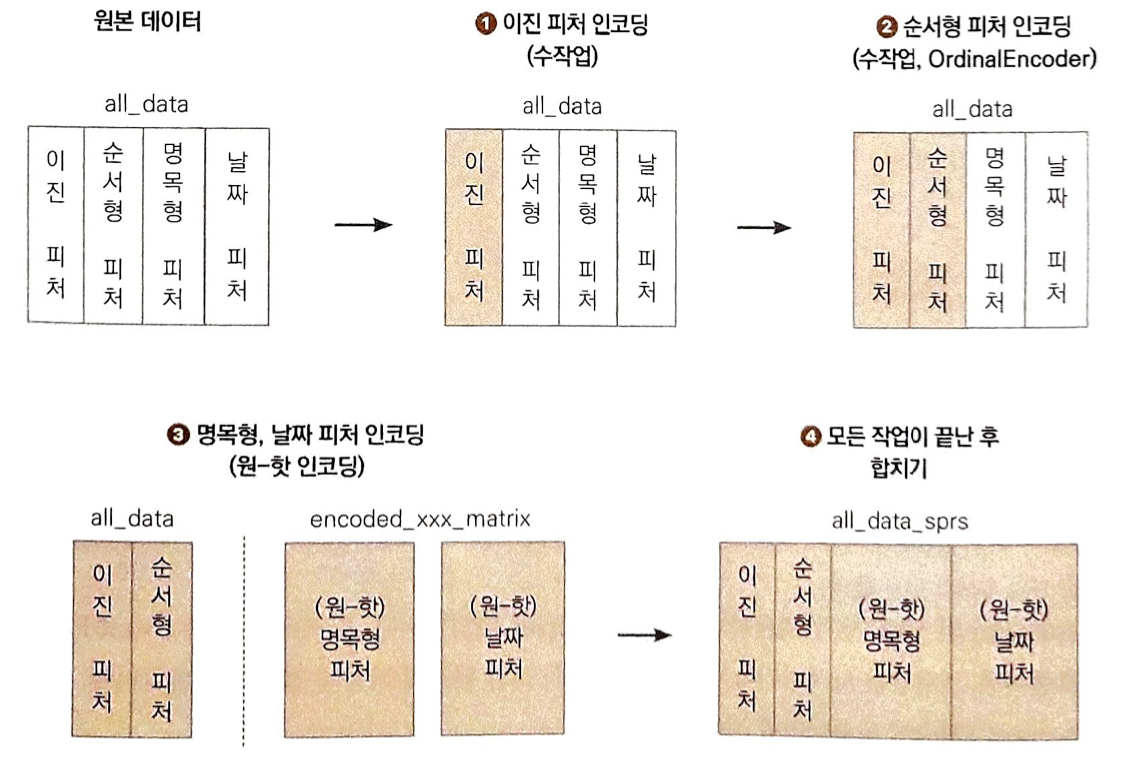

all_data는 훈련 데이터와 테스트 데이터를 합친 데이터로, 이진 피처, 순서형 피처, 명목형 피처, 날짜 피처가 모두 존재합니다. 여기서 이진 피처와 순서형 피처는 적절히 인코딩해서 all_data에 바로 적용할 겁니다.

명목형 피처와 날짜 피처는 원~핫 인코딩해 별도의 행렬로 저장해둡니다. all_data에 바로 적용하지 못하는 이유는 원-핫 인코딩을 하면 열 개수가 많아지기 때문입니다. 그리고 이때 all_data에서 기존의 명목형 피처와 날짜 피처는 삭제합니다.

마지막으로 all_data와 원-핫 인코딩된 명목형 피처와 날짜 피처를 합치겠습니다. 단, 합치는 작업은 피처 스케일링까지 모두 끝낸 뒤에 하겠습니다.

### 데이터 합치기

인코딩 전에 훈련 데이터와 테스트 데이터를 합쳐 all_data를 만들고 타깃값은 제거합니다.

In [2]:
# 훈련 데이터와 테스트 데이터 합치기
all_data = pd.concat([train, test])
all_data = all_data.drop('target', axis=1) # 타깃값 제거

### 이진 피처 인코딩

첫 번째로 이진 피처를 인코딩하겠습니다.

'이진 피처 요약표'에서 봤듯이 bin_0, bin_1, bin_2 피처는 이미 0과 1로만 잘 구성돼 있어 따로 인코딩하지 않아도 됩니다.

반면 bin_3와 bin_4 피처는 각각 T와 F, Y와 N이라는 문자로 구성돼 있습니다. 각각 1과 0으로 바꾸겠습니다. 이때 판다스의 `map()` 함수를 사용합니다.

In [3]:
all_data['bin_3'] = all_data['bin_3'].map({'F':0, 'T':1})
all_data['bin_4'] = all_data['bin_4'].map({'N':0, 'Y':1})

DataFrame의 열(피처)을 호출하면 반환값이 Series 타입입니다. Series 객체에 `map()` 함수를 호출하면, 전달받은 딕셔너리나 함수를 Series의 모든 원소에 적용해 결과를 반환합니다. 여기서는 `map()` 함수에 딕셔너리를 전달했습니다.

딕셔너리를 이용해 bin_3의 F는 0으로, T는 1로 바꿨습니다. 마찬가지로 bin_4도 N은 0으로,Y는 1로 바꿨습니다. 이상으로 이진 피처들은 수작업으로 간단하게 인코딩을 완료했습니다.

### 순서형 피처 인코딩

다음으로 순서형 피처를 인코딩하겠습니다. 순서형 피처의 고윳값은 다음과 같습니다.

In [4]:
for i in range(0, 6):
    feature = 'ord_' + str(i)
    print(f'{feature} 고윳값: {train[feature].unique()}')

ord_0 고윳값: [2 1 3]
ord_1 고윳값: ['Grandmaster' 'Expert' 'Novice' 'Contributor' 'Master']
ord_2 고윳값: ['Cold' 'Hot' 'Lava Hot' 'Boiling Hot' 'Freezing' 'Warm']
ord_3 고윳값: ['h' 'a' 'i' 'j' 'g' 'e' 'd' 'b' 'k' 'f' 'l' 'n' 'o' 'c' 'm']
ord_4 고윳값: ['D' 'A' 'R' 'E' 'P' 'K' 'V' 'Q' 'Z' 'L' 'F' 'T' 'U' 'S' 'Y' 'B' 'H' 'J'
 'N' 'G' 'W' 'I' 'O' 'C' 'X' 'M']
ord_5 고윳값: ['kr' 'bF' 'Jc' 'kW' 'qP' 'PZ' 'wy' 'Ed' 'qo' 'CZ' 'qX' 'su' 'dP' 'aP'
 'MV' 'oC' 'RL' 'fh' 'gJ' 'Hj' 'TR' 'CL' 'Sc' 'eQ' 'kC' 'qK' 'dh' 'gM'
 'Jf' 'fO' 'Eg' 'KZ' 'Vx' 'Fo' 'sV' 'eb' 'YC' 'RG' 'Ye' 'qA' 'lL' 'Qh'
 'Bd' 'be' 'hT' 'lF' 'nX' 'kK' 'av' 'uS' 'Jt' 'PA' 'Er' 'Qb' 'od' 'ut'
 'Dx' 'Xi' 'on' 'Dc' 'sD' 'rZ' 'Uu' 'sn' 'yc' 'Gb' 'Kq' 'dQ' 'hp' 'kL'
 'je' 'CU' 'Fd' 'PQ' 'Bn' 'ex' 'hh' 'ac' 'rp' 'dE' 'oG' 'oK' 'cp' 'mm'
 'vK' 'ek' 'dO' 'XI' 'CM' 'Vf' 'aO' 'qv' 'jp' 'Zq' 'Qo' 'DN' 'TZ' 'ke'
 'cG' 'tP' 'ud' 'tv' 'aM' 'xy' 'lx' 'To' 'uy' 'ZS' 'vy' 'ZR' 'AP' 'GJ'
 'Wv' 'ri' 'qw' 'Xh' 'FI' 'nh' 'KR' 'dB' 'BE' 'Bb' 'mc' 'MC' 'tM' 'NV'
 'i

ord_0 피처는 이미 숫자로 구성돼 있어 인코딩하지 않아도 됩니다. ord_1과 ord_2 피처는 순서를 정해서 인코딩해보겠습니다. ord_3부터 ord_5는 알파벳 순서대로 인코딩해야 합니다.

ord_1과 ord_2 피처부터 인코딩해봅시다. 이번에도 `map()` 함수를 사용해 수작업으로 인코딩합니다. 이때 피처 값 순서에 유의해야 합니다.

In [5]:
ord1dict = {'Novice':0, 'Contributor':1, 
            'Expert':2, 'Master':3, 'Grandmaster':4}
ord2dict = {'Freezing':0, 'Cold':1, 'Warm':2, 
            'Hot':3, 'Boiling Hot':4, 'Lava Hot':5}

all_data['ord_1'] = all_data['ord_1'].map(ord1dict)
all_data['ord_2'] = all_data['ord_2'].map(ord2dict)

ord_1, ord_2 피처 인코딩이 끝났습니다.

다음은 ord_3, ord_4, ord_5 차례입니다. 이 피처들은 알파벳 순서대로 인코딩해야 합니다. 사이킷런의 OrdinalEncoder를 사용하면 됩니다.

ord_3, ord_4, ord_5 피처도 물론 알파벳순으로 정렬한 다음 map() 함수로 인코딩해도 됩니다. 하지만 고육값 개수가 많아 번거롭기 때문에 OrdinalEncoder를 사용하는 것입니다.

우선 OrdinalEncoder 객체를 생성하고, ord_3, ord_4, ord_5 피처에 `fit_transform()` 을 적용해 인코딩합니다. 알파벳순으로 잘 인코딩됐는지도 출력해보겠습니다.

In [6]:
from sklearn.preprocessing import OrdinalEncoder

ord_345 = ['ord_3', 'ord_4', 'ord_5']

ord_encoder = OrdinalEncoder() # OrdinalEncoder 객체 생성

# ordinal 인코딩 적용
all_data[ord_345] = ord_encoder.fit_transform(all_data[ord_345])

# 피처별 인코딩 순서 출력
for feature, categories in zip(ord_345, ord_encoder.categories_):
    print(feature)
    print(categories)

ord_3
['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o']
ord_4
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']
ord_5
['AP' 'Ai' 'Aj' 'BA' 'BE' 'Bb' 'Bd' 'Bn' 'CL' 'CM' 'CU' 'CZ' 'Cl' 'DH'
 'DN' 'Dc' 'Dx' 'Ed' 'Eg' 'Er' 'FI' 'Fd' 'Fo' 'GD' 'GJ' 'Gb' 'Gx' 'Hj'
 'IK' 'Id' 'JX' 'Jc' 'Jf' 'Jt' 'KR' 'KZ' 'Kf' 'Kq' 'LE' 'MC' 'MO' 'MV'
 'Mf' 'Ml' 'Mx' 'NV' 'Nf' 'Nk' 'OR' 'Ob' 'Os' 'PA' 'PQ' 'PZ' 'Ps' 'QM'
 'Qb' 'Qh' 'Qo' 'RG' 'RL' 'RP' 'Rm' 'Ry' 'SB' 'Sc' 'TR' 'TZ' 'To' 'UO'
 'Uk' 'Uu' 'Vf' 'Vx' 'WE' 'Wc' 'Wv' 'XI' 'Xh' 'Xi' 'YC' 'Yb' 'Ye' 'ZR'
 'ZS' 'Zc' 'Zq' 'aF' 'aM' 'aO' 'aP' 'ac' 'av' 'bF' 'bJ' 'be' 'cA' 'cG'
 'cW' 'ck' 'cp' 'dB' 'dE' 'dN' 'dO' 'dP' 'dQ' 'dZ' 'dh' 'eG' 'eQ' 'eb'
 'eg' 'ek' 'ex' 'fO' 'fh' 'gJ' 'gM' 'hL' 'hT' 'hh' 'hp' 'iT' 'ih' 'jS'
 'jV' 'je' 'jp' 'kC' 'kE' 'kK' 'kL' 'kU' 'kW' 'ke' 'kr' 'kw' 'lF' 'lL'
 'll' 'lx' 'mb' 'mc' 'mm' 'nX' 'nh' 'oC' 'oG' 'oH' 'oK' 'od' 'on' 'pa'
 'ps' 'qA' 'qJ' 'qK' 'qP' 'qX' '

ord_encoder.categories_는 어떤 순서로 ordinal 인코딩을 적용했는지 보여줍니다. 출력 결과를 보니 알파벳순으로 제대로 인코딩됐네요.

### 명목형 피처 인코딩

명목형 피처는 순서를 무시해도 되기 때문에 원-핫 인코딩을 적용하겠습니다. 먼저 지능형 리스트를 활용해 명목형 피처 리스트를 만듭니다. 명목형 피처는 nom_0부터 nom_9까지 총 10개입니다.

In [7]:
nom_features = ['nom_' + str(i) for i in range(10)] # 명목형 피처

In [8]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder() # OneHotEncoder 객체 생성
# 원-핫 인코딩 적용
encoded_nom_matrix = onehot_encoder.fit_transform(all_data[nom_features])

encoded_nom_matrix

<500000x16276 sparse matrix of type '<class 'numpy.float64'>'
	with 5000000 stored elements in Compressed Sparse Row format>

OneHotEncoder로 원-핫 인코딩을 적용하면 희소 행렬을 CSR 형식으로 반환합니다. 출력 결과를 보면 원-핫 인코딩된 명목형 피처의 행렬 크기가 (500000 x 16276)입니다. 원-핫 인코딩때문에 열이 16,276개나 생성된 겁니다.

희소 행렬과 COO, CSR 형식

대부분 값이 0으로 채워진 행렬을 희소 행렬(sparse matrix)이라고 합니다. 반대로 대부분 값이 0이 아닌 값으로 채워진 행렬을 밀집 행렬(dense matrix)이라고 합니다. 원핫 인코딩을 적용하면 희소 행렬을 만듭니다. 그러면 메모리 낭비가 심해지겠죠? 행렬 크기도 늘어서 연산 시간도 오래 걸립니다.

이런 문제를 개선하도록 행렬 형식을 변환해줘야 합니다. 대표적으로 COO(coordinate list) 형식 과 CSR(compressed sparse row) 형식이 있습니다. 희소 행렬을 COO 형식이나 CSR 형식으로 표현하면 메모리 낭비를 줄일 수 있습니다. 이중에서도 CSR 형식이 메모리를 더 적게 쓰면서 연산도 빠릅니다. 그래서 일반적으로 COO 형식보다 CSR 형식을 많이 씁니다.

명목형 피처를 원-핫 인코딩한 결과를 encoded_nom_matrix에 저장했습니다. 이는 CSR 형식의 행렬입니다.

마지막으로 all_data에서 기존 명목형 피처를 삭제하겠습니다. 추후 encoded_nom_matrix와 all_data를 합칠 텐데, 그러면 하나의 피처가 형식만 다르게 중복되어 들어가기 때문입니다.

In [9]:
all_data = all_data.drop(nom_features, axis=1) # 기존 명목형 피처 삭제

### 날짜 피처 인코딩

day와 month는 날짜 피처입니다. 날짜 피처에도 원-핫 인코딩을 적용하겠습니다.

In [10]:
date_features  = ['day', 'month'] # 날짜 피처

# 원-핫 인코딩 적용
encoded_date_matrix = onehot_encoder.fit_transform(all_data[date_features])

all_data = all_data.drop(date_features, axis=1) # 기존 날짜 피처 삭제

encoded_date_matrix

<500000x19 sparse matrix of type '<class 'numpy.float64'>'
	with 1000000 stored elements in Compressed Sparse Row format>

원-핫 인코딩된 행렬 크기는 (500000 x 19)입니다. day 피처 고윳값은 7개, month 피처 고육값은 12개라서 인코딩 후 열이 총 19개가 되었습니다.

<br>

## 2. 피처 엔지니어링 II : 피처 스케일링

앞에서도 이야기했듯이 피처 스케일링(feature scaling)이란 서로 다른 피처들의 값의 범위가 일치하도록 조정하는 작업입니다. 피처 스케일링이 필요한 이유는 수치형 피처들의 유효 값 범위가 서로 다르면 훈련이 제대로 안 될 수도 있기 때문입니다.

우리의 경우 앞 절에서 이진, 명목형, 날짜 피처를 모두 0과 1로 인코딩했습니다. 하지만 순서형 피처는 여전히 여러 가지 값을 갖고 있으므로 순서형 피처의 값 범위도 0~1 사이가 되도록 스케일링 해주겠습니다.

### 순서형 피처 스케일링

다른 피처들과 범위를 맞추기 위해 순서형 피처에 min-max 정규화를 적용하겠습니다. min-max 정규화는 피처 값의 범위를 0~1로 조정합니다.

In [11]:
from sklearn.preprocessing import MinMaxScaler

ord_features = ['ord_' + str(i) for i in range(6)] # 순서형 피처

# min-max 정규화
all_data[ord_features] = MinMaxScaler().fit_transform(all_data[ord_features])

이상으로 모든 피처의 값 범위가 0~1로 맞춰졌습니다.

이상으로 모든 피처가 적절히 인코딩됐고, 피처 값들의 범위도 같아졌습니다.

### 인코딩 및 스케일링된 피처 합치기

현재 all_data에는 이진 피처와 순서형 피처가 인코딩돼 있습니다. 명목형 피처와 날짜 피처는 원-핫 인코딩되어 각각 encoded_nom_matrix와 encoded_date_matrix에 저장돼 있습니다. 이제 이 세 데이터를 합치겠습니다.

그런데 all_data는 DataFrame이고, encoded_nom_matrix와 encoded_date_matrix는 CSR 형식의 행렬입니다. 형식이 서로 다르니 맞춰줘야겠죠? all_data를 CSR 형식으로 만들어 합치겠습니다. 사이파이가 제공하는 `csr_matrix()` 는 전달받은 데이터를 CSR 형식으로 바꿔줍니다.

In [12]:
from scipy import sparse

# 인코딩 및 스케일링된 피처 합치기
all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data),
                               encoded_nom_matrix,
                               encoded_date_matrix],
                              format='csr')

여기서 `hstack()` 은 행렬을 수평 방향으로 합칩니다. 그리고 format='csr'을 전달하면 합친 결과를 CSR 형식으로 반환합니다(기본값은 COO 형식입니다). 인코딩된 모든 피처를 합친 all_data_sprs를 출력해봅시다.

In [13]:
all_data_sprs

<500000x16306 sparse matrix of type '<class 'numpy.float64'>'
	with 9163718 stored elements in Compressed Sparse Row format>

500,000행 16,306열로 구성돼 있네요. 이 정도 크기를 DataFrame으로 처리하면 메모리 낭비가 심하고 훈련 속도도 떨어집니다. 따라서 DataFrame으로 변환하지 않고, CSR 형식을 그대로 사용하겠습니다.

이상으로 피처 엔지니어링을 모두 마쳤습니다.

### 데이터 나누기

마지막으로 훈련 데이터와 테스트 데이터를 나눕니다.

In [14]:
num_train = len(train) # 훈련 데이터 개수

# 훈련 데이터와 테스트 데이터 나누기
X_train = all_data_sprs[:num_train] # 0 ~ num_train - 1행
X_test = all_data_sprs[num_train:] # num_train ~ 마지막 행

y = train['target']

y는 모델 훈련 시 필요한 타깃값(정답)입니다.

베이스라인과 마찬가지로 훈련 데이터를 다시 훈련 데이터와 검증 데이터로 나누겠습니다.

In [15]:
from sklearn.model_selection import train_test_split

# 훈련 데이터, 검증 데이터 분리
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y,
                                                      test_size=0.1,
                                                      stratify=y,
                                                      random_state=10)

## 3. 하이퍼파라미터 최적화

이번 절에서는 최종 데이터를 활용해 모델을 훈련하고 결과를 제출하겠습니다. 이 과정에서 베이스라인 모델과 달리 하이퍼파라미터를 최적화해보겠습니다.

그리드서치를 활용해 로지스틱 회귀 모델의 하이퍼파라미터를 최적화해보겠습니다. 탐색할 하이퍼파라미터는 C와 max_iter입니다. C는 규제 강도를 조절하는 파라미터로, 값이 작을수록 규제 강도가 세집니다.

모델을 생성하고 평가지표를 ROC AUC로 지정해 그리드서치를 수행해보겠습니다. 참고로, 다음 코드는 실행하는 데 수분이 걸립니다. 첫 줄의 %%time은 해당 셀실행 후 소요 시간을 출력해 주는 기능입니다.

In [16]:
# %%time

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# 로지스틱 회귀 모델 생성
logistic_model = LogisticRegression()

# 하이퍼파라미터 값 목록
lr_params = {'C':[0.1, 0.125, 0.2], 'max_iter':[800, 900, 1000], 
             'solver':['liblinear'], 'random_state':[42]}

# 그리드서치 객체 생성
gridsearch_logistic_model = GridSearchCV(estimator=logistic_model,
                                         param_grid=lr_params,
                                         scoring='roc_auc', # 평가지표
                                         cv=5)
# 그리드서치 수행
gridsearch_logistic_model.fit(X_train, y_train)

print('최적 하이퍼파라미터:', gridsearch_logistic_model.best_params_)

최적 하이퍼파라미터: {'C': 0.125, 'max_iter': 800, 'random_state': 42, 'solver': 'liblinear'}


CPU 시간의 총합이 Wall time보다 큰 이유는 이 코드를 병렬로 실행했기 때문입니다. CPU 시간은 개별 코어의 수행 시간을 모두 합친 값입니다.

최적 하이퍼파라미터는 C: 0.125, max_iter: 800입니다.

<br>

## 4. 모델 성능 검증

최적 하이퍼파라미터를 찾았으니 모델 성능이 얼마나 개선되었는지 봐야겠죠? 베이스라인처럼 검증 데이터로 모델 성능을 검증해보겠습니다. 먼저 검증 데이터로 타깃 예측값을 구합니다.

In [17]:
y_valid_preds = gridsearch_logistic_model.predict_proba(X_valid)[:, 1]

이어서 검증 데이터 ROC AUC를 구해보죠.

In [18]:
from sklearn.metrics import roc_auc_score # ROC AUC 점수 계산 함수

# 검증 데이터 ROC AUC
roc_auc = roc_auc_score(y_valid, y_valid_preds)

print(f'검증 데이터 ROC AUC : {roc_auc:.4f}')

검증 데이터 ROC AUC : 0.8045


ROC AUC가 0.8045입니다. 베이스라인 모델보다 0.008만큼 향상되었군요.

## 5. 예측 및 결과 제출

제출 파일을 만들어 커밋 후 제출해보겠습니다.

In [19]:
# 타깃값 1일 확률 예측
y_preds = gridsearch_logistic_model.best_estimator_.predict_proba(X_test)[:,1]

# 제출 파일 생성
submission['target'] = y_preds
submission.to_csv('submission.csv')

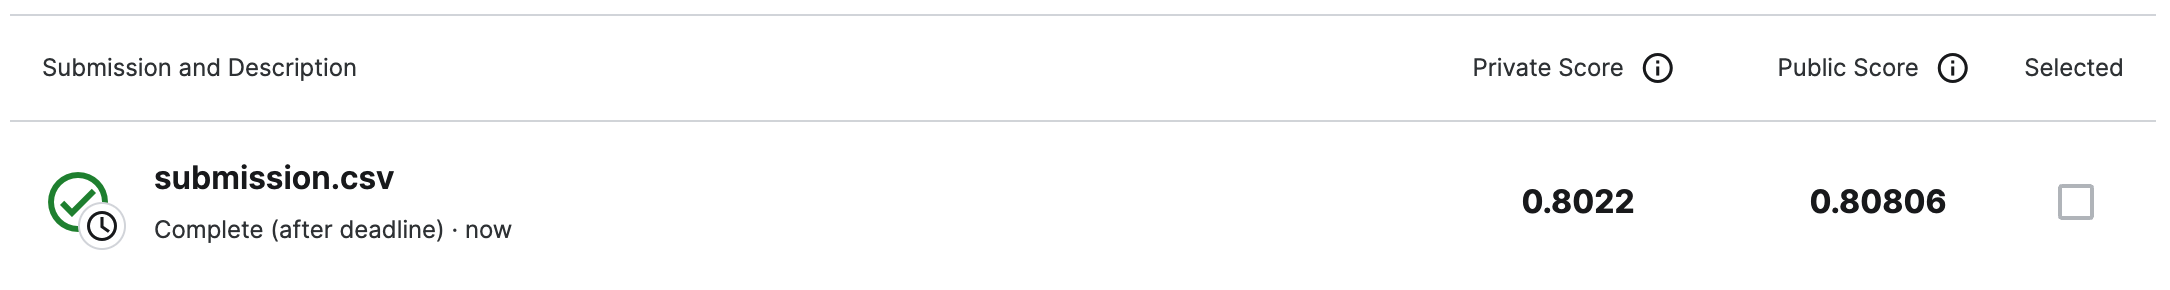

베이스라인 모델보다 점수가 높습니다. 프라이빗 점수 기준으로 전체 428 등으로 상위 32%입니다. 여전히 등수가 높지 않네요. 만족스럽지 않습니다. 성능을 더 높여보죠.

베이스라인 모델보다 프라이빗 점수는 0.00608점, 퍼블릭 점수는 0.00698점밖에 차이가 안 납니다. 여러 방법을 적용해도 이 정도만 향상된 이유는 기본적으로 베이스라인 모델의 성능이 좋기 때문입니다. 실제로 이번 대회의 1등점수는 0.80283점으로, 우리 베이스라인보다 0.00671점, 이번 결과보다는 겨우 0.00063점이 높을 뿐입니다. 실무에서는 이 정도 차이는 큰 의미가 없을 수 있습니다. 하지만 캐글 경진대회에서는 0.0001점 차이로 메달 색이 달라지기도 합니다.

<br>

# 2. Modeling II

지금까지 피처 엔지니어링과 하이퍼파라미터 최적화로 428등까지 기록했습니다. 이번에는 간단한 방법으로 더 위로 올라가보겠습니다.

앞서 모델 훈련 시 전체 훈련 데이터를 9:1 비율로 훈련 데이터와 검증 데이터로 나눴습니다. 훈련 데이터는 훈련용으로만 사용하고, 검증 데이터는 모델 성능 검증용으로만 사용했죠.

검증 데이터는 전체 훈련 데이터의 10%를 차지합니다. 이렇게 많은 데이터를 검증용으로만 사용하고 훈련에는 사용하지 않으니 조금 아깝습니다. 그러니 지금까지 다룬 모델링 절차를 그대로 유지한 채로 훈련 데이터 전체를 사용해 모델을 훈련해보겠습니다. train_test_split()으로 훈련데이터(90%)와 검증 데이터(10%)로 나누는 부분과 연관된 코드를 제외하고 나머지 모든 절차는  동일하게 수행하는 겁니다.

다만 훈련 데이터가 달라지면 그에 따라 최적 하이퍼파라미터도 달라질 수 있습니다. 가령, 훈련 데이터 90%를 사용해 구한 최적 하이퍼파라미터가 훈련 데이터 100%를 사용할 때도 최적이라는 보장은 없습니다. 거의 비슷하겠지만 말이죠.

In [20]:
import pandas as pd

# 데이터 경로
data_path = '/kaggle/input/cat-in-the-dat/'

train = pd.read_csv(data_path + 'train.csv', index_col='id')
test = pd.read_csv(data_path + 'test.csv', index_col='id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id')

## 1. 피처 엔지니어링 I : 피처 맞춤 인코딩

### 데이터 합치기

In [21]:
# 훈련 데이터와 테스트 데이터 합치기
all_data = pd.concat([train, test])
all_data = all_data.drop('target', axis=1) # 타깃 값 제거

### 이진 피처 인코딩

In [22]:
all_data['bin_3'] = all_data['bin_3'].map({'F':0, 'T':1})
all_data['bin_4'] = all_data['bin_4'].map({'N':0, 'Y':1})

### 순서형 피처 인코딩

In [23]:
ord1dict = {'Novice':0, 'Contributor':1, 
            'Expert':2, 'Master':3, 'Grandmaster':4}
ord2dict = {'Freezing':0, 'Cold':1, 'Warm':2, 
            'Hot':3, 'Boiling Hot':4, 'Lava Hot':5}

all_data['ord_1'] = all_data['ord_1'].map(ord1dict)
all_data['ord_2'] = all_data['ord_2'].map(ord2dict)

In [24]:
from sklearn.preprocessing import OrdinalEncoder

ord_345 = ['ord_3', 'ord_4', 'ord_5']

ord_encoder = OrdinalEncoder() # OrdinalEncoder 객체 생성
# ordinal 인코딩 적용
all_data[ord_345] = ord_encoder.fit_transform(all_data[ord_345])

# 피처별 인코딩 순서 출력
for feature, categories in zip(ord_345, ord_encoder.categories_):
    print(feature)
    print(categories)

ord_3
['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o']
ord_4
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']
ord_5
['AP' 'Ai' 'Aj' 'BA' 'BE' 'Bb' 'Bd' 'Bn' 'CL' 'CM' 'CU' 'CZ' 'Cl' 'DH'
 'DN' 'Dc' 'Dx' 'Ed' 'Eg' 'Er' 'FI' 'Fd' 'Fo' 'GD' 'GJ' 'Gb' 'Gx' 'Hj'
 'IK' 'Id' 'JX' 'Jc' 'Jf' 'Jt' 'KR' 'KZ' 'Kf' 'Kq' 'LE' 'MC' 'MO' 'MV'
 'Mf' 'Ml' 'Mx' 'NV' 'Nf' 'Nk' 'OR' 'Ob' 'Os' 'PA' 'PQ' 'PZ' 'Ps' 'QM'
 'Qb' 'Qh' 'Qo' 'RG' 'RL' 'RP' 'Rm' 'Ry' 'SB' 'Sc' 'TR' 'TZ' 'To' 'UO'
 'Uk' 'Uu' 'Vf' 'Vx' 'WE' 'Wc' 'Wv' 'XI' 'Xh' 'Xi' 'YC' 'Yb' 'Ye' 'ZR'
 'ZS' 'Zc' 'Zq' 'aF' 'aM' 'aO' 'aP' 'ac' 'av' 'bF' 'bJ' 'be' 'cA' 'cG'
 'cW' 'ck' 'cp' 'dB' 'dE' 'dN' 'dO' 'dP' 'dQ' 'dZ' 'dh' 'eG' 'eQ' 'eb'
 'eg' 'ek' 'ex' 'fO' 'fh' 'gJ' 'gM' 'hL' 'hT' 'hh' 'hp' 'iT' 'ih' 'jS'
 'jV' 'je' 'jp' 'kC' 'kE' 'kK' 'kL' 'kU' 'kW' 'ke' 'kr' 'kw' 'lF' 'lL'
 'll' 'lx' 'mb' 'mc' 'mm' 'nX' 'nh' 'oC' 'oG' 'oH' 'oK' 'od' 'on' 'pa'
 'ps' 'qA' 'qJ' 'qK' 'qP' 'qX' '

### 명목형 피처 인코딩

In [25]:
nom_features = ['nom_' + str(i) for i in range(10)] # 명목형 피처

In [26]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder() # OneHotEncoder 객체 생성
# 원-핫 인코딩 적용
encoded_nom_matrix = onehot_encoder.fit_transform(all_data[nom_features])

encoded_nom_matrix

<500000x16276 sparse matrix of type '<class 'numpy.float64'>'
	with 5000000 stored elements in Compressed Sparse Row format>

In [27]:
all_data = all_data.drop(nom_features, axis=1) # 기존 명목형 피처 삭제

### 날짜 피처 인코딩

In [28]:
date_features  = ['day', 'month'] # 날짜 피처

# 원-핫 인코딩 적용
encoded_date_matrix = onehot_encoder.fit_transform(all_data[date_features])

all_data = all_data.drop(date_features, axis=1) # 기존 날짜 피처 삭제

encoded_date_matrix

<500000x19 sparse matrix of type '<class 'numpy.float64'>'
	with 1000000 stored elements in Compressed Sparse Row format>

<br>

## 2. 피처 엔지니어링 II : 피처 스케일링

### 순서형 피처 스케일링

In [29]:
from sklearn.preprocessing import MinMaxScaler

ord_features = ['ord_' + str(i) for i in range(6)] # 순서형 피처
# min-max 정규화
all_data[ord_features] = MinMaxScaler().fit_transform(all_data[ord_features])

### 인코딩 및 스케일링된 피처 합치기

In [30]:
from scipy import sparse

# 인코딩 및 스케일링된 피처 합치기
all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data),
                               encoded_nom_matrix,
                               encoded_date_matrix],
                              format='csr')

In [31]:
all_data_sprs

<500000x16306 sparse matrix of type '<class 'numpy.float64'>'
	with 9163718 stored elements in Compressed Sparse Row format>

### 데이터 나누기

In [32]:
num_train = len(train) # 훈련 데이터 개수

# 훈련 데이터와 테스트 데이터 나누기
X_train = all_data_sprs[:num_train] # 0 ~ num_train - 1행
X_test = all_data_sprs[num_train:] # num_train ~ 마지막 행

y = train['target']

### 하이퍼 파라미터 최적화

In [33]:
%%time

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# 로지스틱 회귀 모델 생성
logistic_model = LogisticRegression()

# 하이퍼파라미터 값 목록
lr_params = {'C':[0.1, 0.125, 0.2], 'max_iter':[800, 900, 1000], 
             'solver':['liblinear'], 'random_state':[42]}

# 그리드서치 객체 생성
gridsearch_logistic_model = GridSearchCV(estimator=logistic_model,
                                         param_grid=lr_params,
                                         scoring='roc_auc', # 평가지표
                                         cv=5)
# 그리드서치 수행
gridsearch_logistic_model.fit(X_train, y)

print('최적 하이퍼파라미터:', gridsearch_logistic_model.best_params_)

최적 하이퍼파라미터: {'C': 0.125, 'max_iter': 800, 'random_state': 42, 'solver': 'liblinear'}
CPU times: user 21min 42s, sys: 16min 32s, total: 38min 15s
Wall time: 10min


<br>

## 3. 예측 및 결과 제출

커밋 후 제출까지 합니다.

In [34]:
# 타깃값 1일 확률 예측
y_preds = gridsearch_logistic_model.best_estimator_.predict_proba(X_test)[:,1]

# 제출 파일 생성
submission['target'] = y_preds
submission.to_csv('submission2.csv')

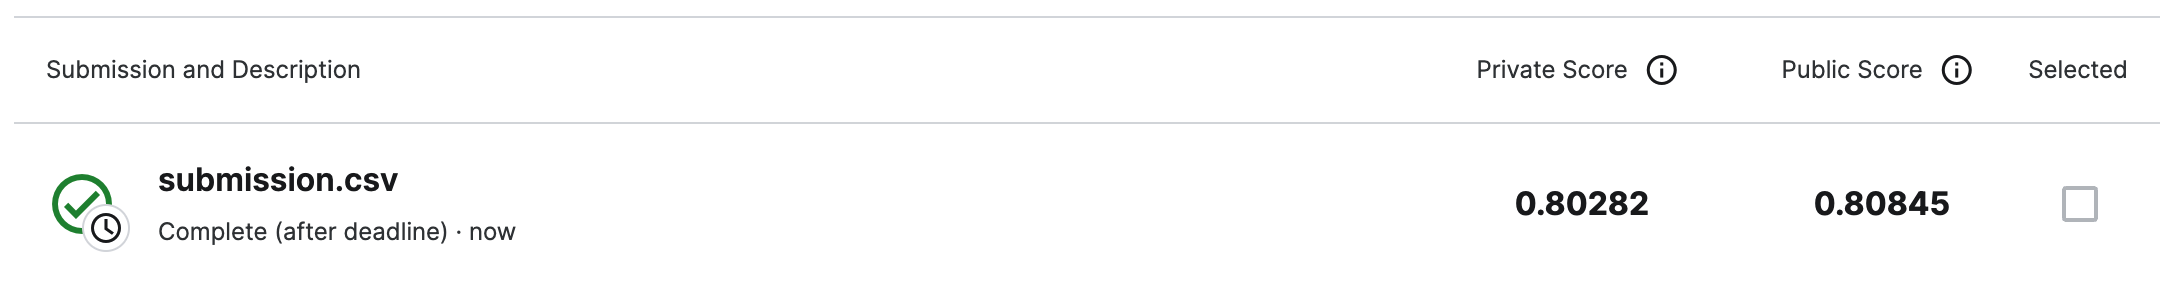

프라이빗 점수가 0.80282군요. 90%의 훈련 데이터만으로 모델링했을 때는 프라이빗 점수가 0.80220이었으니 0.0062만큼 향상되었습니다. 프라이빗 리더보드에서 1등 점수는 0.80283, 2등 점수는 0.80282입니다. 마침내 전체 2등인 점수를 기록했습니다.

지금까지 베이스라인부터 시작해서 차근차근 데이터와 모델을 가공해 점수를 올려봤습니다. 대부분의 경진대회 모델링은 이런 방식으로 진행됩니다.